In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from urllib.request import urlopen  
import os.path as osp
import os
import logging
import zipfile
from glob import glob
logging.getLogger().setLevel('INFO')

## Helpers

In [2]:
def download_file(url_str, path):
    url = urlopen(url_str)
    output = open(path, 'wb')       
    output.write(url.read())
    output.close()  
    
def extract_file(archive_path, target_dir):
    zip_file = zipfile.ZipFile(archive_path, 'r')
    zip_file.extractall(target_dir)
    zip_file.close()

## Download the dataset

In [3]:
BASE_URL = 'http://tennis-data.co.uk'
DATA_DIR = "tennis_data"
ATP_DIR = './{}/ATP'.format(DATA_DIR)
WTA_DIR = './{}/WTA'.format(DATA_DIR)

ATP_URLS = [BASE_URL + "/%i/%i.zip" % (i,i) for i in range(2000,2019)]
WTA_URLS = [BASE_URL + "/%iw/%i.zip" % (i,i) for i in range(2007,2019)]

os.makedirs(osp.join(ATP_DIR, 'archives'), exist_ok=True)
os.makedirs(osp.join(WTA_DIR, 'archives'), exist_ok=True)

for files, directory in ((ATP_URLS, ATP_DIR), (WTA_URLS, WTA_DIR)):
    for dl_path in files:
        logging.info("downloading & extracting file %s", dl_path)
        archive_path = osp.join(directory, 'archives', osp.basename(dl_path))
        download_file(dl_path, archive_path)
        extract_file(archive_path, directory)
    
ATP_FILES = sorted(glob("%s/*.xls*" % ATP_DIR))
WTA_FILES = sorted(glob("%s/*.xls*" % WTA_DIR))

df_atp = pd.concat([pd.read_excel(f) for f in ATP_FILES], ignore_index=True)
df_wta = pd.concat([pd.read_excel(f) for f in WTA_FILES], ignore_index=True)

logging.info("%i matches ATP in df_atp", df_atp.shape[0])
logging.info("%i matches WTA in df_wta", df_wta.shape[0])

INFO:root:downloading & extracting file http://tennis-data.co.uk/2000/2000.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2001/2001.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2002/2002.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2003/2003.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2004/2004.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2005/2005.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2006/2006.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2007/2007.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2008/2008.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2009/2009.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2010/2010.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2011/2011.zip
INFO:root:downloading & extracting file http://tenni

## Your work

In [4]:
df_atp.head()

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,...,UBW,UBL,LBW,LBL,SJW,SJL,MaxW,MaxL,AvgW,AvgL
0,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Dosedel S.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Enqvist T.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Escude N.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Federer R.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Fromberg R.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Who are the three ATP players with the most wins?

In [5]:
df_atp.Winner.value_counts()[:3].reset_index()

,Winner,count
0,Federer R.,1121
1,Nadal R.,891
2,Djokovic N.,802


# How many sets did the player “Federer R.” win in total?

In [6]:
df_atp['Wsets'] = pd.to_numeric(df_atp['Wsets'], errors='coerce')
df_atp['Lsets'] = pd.to_numeric(df_atp['Lsets'], errors='coerce')
set_total = df_atp[(df_atp.Winner == 'Federer R.')].Wsets.sum() + df_atp[(df_atp.Loser == 'Federer R.')].Lsets.sum()
print(f'Federer R won {set_total} in total')

Federer R won 2695.0 in total


# How many sets did the player “Federer R.” win during the years 2016 and 2017?


In [7]:
a = df_atp[df_atp.Winner == 'Federer R.'].loc[(df_atp.Date.dt.year == 2016)].Wsets.sum() + df_atp[df_atp.Loser == 'Federer R.'].loc[(df_atp.Date.dt.year == 2016)].Lsets.sum()
b = df_atp[df_atp.Winner == 'Federer R.'].loc[(df_atp.Date.dt.year == 2017)].Wsets.sum() + df_atp[df_atp.Loser == 'Federer R.'].loc[(df_atp.Date.dt.year == 2017)].Lsets.sum()
c = a+b
w = [[a,b, c]]
Fed_Win_16_17 = pd.DataFrame(w, columns=['2016', '2017', 'total'], index= ['fed_wins'])
Fed_Win_16_17

,2016,2017,total
fed_wins,58.0,124.0,182.0


# For each match, what is the percentage of victories of the winner in the past?

In [8]:
def previous_w_percentage(player,date, df_atp):
    minimum_played_games = 2
    df_previous  = df_atp[df_atp["Date"] < date]
    previous_wins = df_previous[df_previous["Winner"] == player].shape[0]
    previous_losses = df_previous[df_previous["Loser"] == player].shape[0]
    
    if  minimum_played_games > (previous_wins + previous_losses):
        return 0
    return previous_wins / (previous_wins + previous_losses)

In [9]:
# df_atp["winner_previous_win_percentage"] = df_atp.apply(
#     lambda row: previous_w_percentage(
#         row["Winner"],
#         row["Date"],
#         df_atp
#     ),
#     axis=1
# )

In [10]:
# df_atp[["Winner","winner_previous_win_percentage"]]

# Machine learning and preprocessing

# Feature engineering

### Feature selections

In [11]:
'''
    the columns : 'L1', 'W2', 'L2', 'W3', 'L3', 'W4', 'L4', 'W5', 'L5', 'Wsets', 'Lsets', 'Comment', 
    etc are not that relevant for my dataset so I will drop them
'''

columns_to_drop = [
    'ATP','L1','W1', 'W2', 'L2', 'W3', 'L3', 'W4', 'L4', 'W5', 'L5','Comment', 'B365W', 'Tournament', 'Location',
    'B365L', 'B&WW', 'B&WL', 'CBW', 'CBL', 'EXW', 'EXL', 'LBW', 'LBL',
    'GBW', 'GBL', 'IWW', 'IWL', 'PSW', 'PSL', 'SBW', 'SBL', 'SJW', 'SJL', 'UBW', 'UBL'
                  ]
df_atp = df_atp.drop(columns_to_drop, axis=1)

## Data summary

In [12]:
print(df_atp.shape)
print("\n")
print(df_atp.info())
print("\n")

print(df_atp.head())
print("\n")

print(df_atp.describe())


(52298, 18)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52298 entries, 0 to 52297
Data columns (total 18 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     52298 non-null  datetime64[ns]
 1   Series   52298 non-null  object        
 2   Court    52298 non-null  object        
 3   Surface  52298 non-null  object        
 4   Round    52298 non-null  object        
 5   Best of  52298 non-null  int64         
 6   Winner   52298 non-null  object        
 7   Loser    52298 non-null  object        
 8   WRank    52283 non-null  object        
 9   LRank    52220 non-null  object        
 10  Wsets    52074 non-null  float64       
 11  Lsets    52072 non-null  float64       
 12  WPts     36094 non-null  float64       
 13  LPts     36035 non-null  float64       
 14  MaxW     22745 non-null  float64       
 15  MaxL     22745 non-null  float64       
 16  AvgW     22745 non-null  float64       
 17  AvgL     22745 no

## Missing values

Date           0
Series         0
Court          0
Surface        0
Round          0
Best of        0
Winner         0
Loser          0
WRank         15
LRank         78
Wsets        224
Lsets        226
WPts       16204
LPts       16263
MaxW       29553
MaxL       29553
AvgW       29553
AvgL       29553
dtype: int64


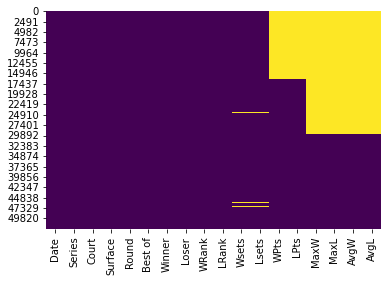

In [13]:
print(df_atp.isnull().sum())
sns.heatmap(df_atp.isnull(), cbar=False, cmap='viridis')
plt.show()

the missing values are in yellow

In [14]:
df_atp['MaxW'].fillna(0, inplace=True)
df_atp['MaxL'].fillna(0, inplace=True)
df_atp['AvgW'].fillna(df_atp['AvgW'].mean(), inplace=True)
df_atp['AvgL'].fillna(df_atp['AvgL'].mean(), inplace=True)
df_atp['Lsets'].fillna(df_atp['Lsets'].mean(), inplace=True)
df_atp['Wsets'].fillna(df_atp['Wsets'].mean(), inplace=True)

#we replace nan value in the ranking column with the previous value of ranking for each player 

df_atp['WRank'] = df_atp.groupby('Winner')['WRank'].fillna(method='ffill').fillna(-1)
df_atp['LRank'] = df_atp.groupby('Loser')['LRank'].fillna(method='ffill').fillna(-1)
df_atp['LPts'].fillna(df_atp['LPts'].mean(), inplace=True)
df_atp['WPts'].fillna(df_atp['WPts'].mean(), inplace=True)


Date       0
Series     0
Court      0
Surface    0
Round      0
Best of    0
Winner     0
Loser      0
WRank      0
LRank      0
Wsets      0
Lsets      0
WPts       0
LPts       0
MaxW       0
MaxL       0
AvgW       0
AvgL       0
dtype: int64


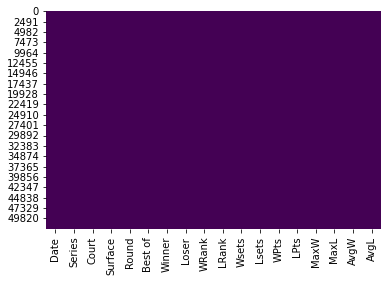

In [15]:
print(df_atp.isnull().sum())
sns.heatmap(df_atp.isnull(), cbar=False, cmap='viridis')
plt.show()

## Target variable


### We are creating a new variable name outcome that will decide the outcome of match. As we cannot take the winner or loser columns as target we will use the LRank and WRank to decide of the value of the outcome

In [16]:
# Assign an initial value of 0 to the 'Outcome' column
df_atp['Outcome'] = 0

def update_outcome(row):
    loser_rank = row['LRank']
    winner_rank = row['WRank']

    # Handle 'NR' (No Rank) values by assigning a small default rank value- for loser and large for winner
    if loser_rank == 'NR':
        loser_rank = 0
    if winner_rank == 'NR':
        winner_rank = 1000

    if int(loser_rank) < int(winner_rank):
        return 0
    else:
        return 1

df_atp['Outcome'] = df_atp.apply(update_outcome, axis=1)

outcome_df = df_atp[['Winner', 'Loser', 'Outcome']]
print(outcome_df.sample(15))


                   Winner           Loser  Outcome
24220            Horna L.      Gasquet R.        0
3337            Henman T.  Vinciguerra A.        1
48292  Estrella Burgos V.   Gabashvili T.        1
36751         Wawrinka S.        Kamke T.        1
21957        Mathieu P.H.     Ljubicic I.        0
40885          Andujar P.        Delic M.        1
49743            Simon G.        Cilic M.        0
23870          Federer R.        Mahut N.        1
2130             Pozzi G.        Pavel A.        0
23640          Roddick A.     Stepanek R.        1
31795          Roddick A.       Hewitt L.        1
19357         Lapentti N.       Koubek S.        0
6132            Rochus C.      Sluiter R.        1
23561         Volandri F.        Massu N.        1
17579          Andreev I.        Seppi A.        1


New column base on the year

In [17]:
df_atp["Year"] = df_atp["Date"].dt.year.tolist()
df_atp["Month"] = df_atp["Date"].dt.month
df_atp["Day"] = df_atp["Date"].dt.day
df_atp["Weekday"] = df_atp["Date"].dt.weekday

df_atp.head()

,Date,Series,Court,Surface,Round,Best of,Winner,Loser,WRank,LRank,...,LPts,MaxW,MaxL,AvgW,AvgL,Outcome,Year,Month,Day,Weekday
0,2000-01-03,International,Outdoor,Hard,1st Round,3,Dosedel S.,Ljubicic I.,63,77.0,...,1047.544665,0.0,0.0,1.834821,3.594448,1,2000,1,3,0
1,2000-01-03,International,Outdoor,Hard,1st Round,3,Enqvist T.,Clement A.,5.0,56.0,...,1047.544665,0.0,0.0,1.834821,3.594448,1,2000,1,3,0
2,2000-01-03,International,Outdoor,Hard,1st Round,3,Escude N.,Baccanello P.,40.0,655.0,...,1047.544665,0.0,0.0,1.834821,3.594448,1,2000,1,3,0
3,2000-01-03,International,Outdoor,Hard,1st Round,3,Federer R.,Knippschild J.,65.0,87,...,1047.544665,0.0,0.0,1.834821,3.594448,1,2000,1,3,0
4,2000-01-03,International,Outdoor,Hard,1st Round,3,Fromberg R.,Woodbridge T.,81,198,...,1047.544665,0.0,0.0,1.834821,3.594448,1,2000,1,3,0


In [18]:
# unique_values = df_atp.nunique()
# binary_columns = unique_values[unique_values == 2].index
# print(binary_columns)

## Categorical to numeric vaiable

In [19]:
cour_binary = {'Outdoor': 0, 'Indoor': 1}
df_atp['Court'] = df_atp['Court'].map(cour_binary)

In [20]:
categorical_columns = df_atp.select_dtypes(include=["object"]).columns

print("Categorical Columns:")
print(categorical_columns)

Categorical Columns:
Index(['Series', 'Surface', 'Round', 'Winner', 'Loser', 'WRank', 'LRank'], dtype='object')


In [21]:
df_atp.drop(columns=['Winner', 'Loser', 'Date'], axis=1, inplace=True)

In [22]:
df_atp.loc[df_atp['LRank'] == 'NR', 'LRank'] = 1000
df_atp.loc[df_atp['WRank'] == 'NR', 'WRank'] = 1000
df_atp['LRank'] = df_atp['LRank'].astype(float)
df_atp['WRank'] = df_atp['WRank'].astype(float)

In [23]:
Series_dummies = pd.get_dummies(df_atp['Series'])
Surface_dummies = pd.get_dummies(df_atp['Surface'])
Round_dummies = pd.get_dummies(df_atp['Round'])

df_atp = pd.concat([df_atp, Series_dummies,Surface_dummies, Round_dummies], axis=1)

# Convert dummy variable columns to numeric
df_atp[Series_dummies.columns] = df_atp[Series_dummies.columns].astype(int)
df_atp[Surface_dummies.columns] = df_atp[Surface_dummies.columns].astype(int)
df_atp[Round_dummies.columns] = df_atp[Round_dummies.columns].astype(int)

df_atp.drop(['Series', 'Surface', 'Round'], axis=1, inplace=True)
df_atp


,Court,Best of,WRank,LRank,Wsets,Lsets,WPts,LPts,MaxW,MaxL,...,Grass,Hard,1st Round,2nd Round,3rd Round,4th Round,Quarterfinals,Round Robin,Semifinals,The Final
0,0,3,63.0,77.0,2.0,0.0,1831.891644,1047.544665,0.00,0.00,...,0,1,1,0,0,0,0,0,0,0
1,0,3,5.0,56.0,2.0,0.0,1831.891644,1047.544665,0.00,0.00,...,0,1,1,0,0,0,0,0,0,0
2,0,3,40.0,655.0,2.0,1.0,1831.891644,1047.544665,0.00,0.00,...,0,1,1,0,0,0,0,0,0,0
3,0,3,65.0,87.0,2.0,0.0,1831.891644,1047.544665,0.00,0.00,...,0,1,1,0,0,0,0,0,0,0
4,0,3,81.0,198.0,2.0,1.0,1831.891644,1047.544665,0.00,0.00,...,0,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52293,1,3,5.0,10.0,2.0,0.0,5085.000000,3155.000000,1.44,3.40,...,0,1,0,0,0,0,0,1,0,0
52294,1,3,1.0,7.0,2.0,0.0,8045.000000,4050.000000,1.22,6.03,...,0,1,0,0,0,0,0,1,0,0
52295,1,3,5.0,3.0,2.0,0.0,5085.000000,6020.000000,3.40,1.45,...,0,1,0,0,0,0,0,0,1,0
52296,1,3,1.0,6.0,2.0,0.0,8045.000000,4310.000000,1.15,7.72,...,0,1,0,0,0,0,0,0,1,0


# Data spliting

In [24]:
from sklearn.model_selection import train_test_split



train_df_atp = df_atp[df_atp['Year'] < 2017]
test_df_atp = df_atp[df_atp['Year'] >= 2017]

train_features = train_df_atp.drop('Outcome', axis=1)
train_target = train_df_atp['Outcome']

test_features = test_df_atp.drop('Outcome', axis=1)
test_target = test_df_atp['Outcome']

print("Training set shape:", train_features.shape, train_target.shape)
print("Testing set shape:", test_features.shape, test_target.shape)


Training set shape: (47028, 36) (47028,)
Testing set shape: (5270, 36) (5270,)


In [30]:

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_features[numeric_features])
X_test_scaled = scaler.transform(test_features[numeric_features])

model = Ridge()
model.fit, train_target)
y_pred = model.predict(X_test_scaled)
y_train_pred = model.predict)

print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))
print("Train RMSE = %.4f" % mean_squared_error(y_train, y_train_pred, squared=False))

,Court,Best of,WRank,LRank,Wsets,Lsets,WPts,LPts,MaxW,MaxL,...,Grass,Hard,1st Round,2nd Round,3rd Round,4th Round,Quarterfinals,Round Robin,Semifinals,The Final
47028,0,3,79.0,160.0,2.0,0.0,689.0,372.0,1.33,3.90,...,0,1,1,0,0,0,0,0,0,0
47029,0,3,39.0,54.0,2.0,1.0,1102.0,854.0,1.59,2.55,...,0,1,1,0,0,0,0,0,0,0
47030,0,3,21.0,26.0,2.0,0.0,1785.0,1465.0,2.15,1.82,...,0,1,1,0,0,0,0,0,0,0
47031,0,3,45.0,141.0,2.0,0.0,1001.0,443.0,1.42,3.25,...,0,1,1,0,0,0,0,0,0,0
47032,0,3,17.0,33.0,2.0,0.0,2035.0,1320.0,1.46,3.13,...,0,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52293,1,3,5.0,10.0,2.0,0.0,5085.0,3155.0,1.44,3.40,...,0,1,0,0,0,0,0,1,0,0
52294,1,3,1.0,7.0,2.0,0.0,8045.0,4050.0,1.22,6.03,...,0,1,0,0,0,0,0,1,0,0
52295,1,3,5.0,3.0,2.0,0.0,5085.0,6020.0,3.40,1.45,...,0,1,0,0,0,0,0,0,1,0
52296,1,3,1.0,6.0,2.0,0.0,8045.0,4310.0,1.15,7.72,...,0,1,0,0,0,0,0,0,1,0


# Model

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


model = LogisticRegression()
model.fit(train_features, train_target)
predictions = model.predict(test_features)

accuracy = accuracy_score(test_target, predictions)
precision = precision_score(test_target, predictions)
recall = recall_score(test_target, predictions)
f1 = f1_score(test_target, predictions)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)


Accuracy: 0.9944971537001898
Precision: 0.9967388081826267
Recall: 0.9946745562130177
F1-Score: 0.9957056123204501


c:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [29]:
scales = pd.Series(data=X_train_scaled.std(axis=0), index=numeric_features)
show_weights(numeric_features, model.coef_, scales)

Index([9, 2, 3, 15, 8, 11, 16, 21, 10, 19], dtype='int64')